In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

class DatasetClass(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Read data
data = fetch_california_housing()
X, y = data.data, data.target


# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)


# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
print(X_train.shape)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Instantiate your dataset
train_dataset = DatasetClass(X_train, y_train)
test_dataset = DatasetClass(X_test, y_test)

(14447, 8)


In [2]:
# Define the model
'''model = nn.Sequential(
    nn.Linear(8, 60),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(60, 60),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(60, 30),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(30, 1),
)'''

class DropoutDeepRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(8, 60)
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(60, 30)
        self.act3 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.output = nn.Linear(30, 1)
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.act3(self.layer3(x))
        x = self.dropout3(x)
        x = self.output(x)
        return x
    
class DeepRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(8, 60)
        self.act1 = nn.LeakyReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.LeakyReLU()
        self.layer3 = nn.Linear(60, 30)
        self.act3 = nn.LeakyReLU()
        self.output = nn.Linear(30, 1)
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.output(x)
        return x

standard_model = DeepRegressor()
dropout_model = DropoutDeepRegressor()
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error

n_epochs = 500   # number of epochs to run
batch_size = 10  # size of each batch

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Hold the best model
  # init to infinity
best_weights = None
history = []

In [3]:
def evaluate(model, data_loader, loss_fn):
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            batch_loss.append(loss.item())

    mse = np.mean(batch_loss)
    return mse

def train_model(model, train_loader, test_loader, loss_fn, n_epochs):

    optimizer = optim.Adam(model.parameters(), lr=0.0001) #weight_decay=0.1
    optimizer_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.666)
    best_mse = np.inf 

    for epoch in range(n_epochs):
            # Training
            model.train()
            batch_loss = []
            with tqdm(total=len(train_loader), unit="batch") as bar:
                bar.set_description(f"Epoch {epoch} (LR={optimizer.param_groups[0]['lr']})")
                optimizer_scheduler.step()
                
                for X_batch, y_batch in train_loader:
                    # Forward pass
                    y_pred = model.forward(X_batch)
                    loss = loss_fn(y_pred, y_batch)
                    
                    # Backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    
                    # Update weights
                    optimizer.step()
                    
                    batch_loss.append(loss.item())
                    bar.set_postfix(mse=np.mean(batch_loss))
                    bar.update(1)

            # Evaluate accuracy at the end of each epoch
            mse = evaluate(model, train_loader, loss_fn)
            history.append(mse)

            # Check if the current model is the best
            if mse < best_mse:
                best_mse = mse
                best_weights = copy.deepcopy(model.state_dict())

    test_mse = evaluate(model, test_loader, loss_fn)

    return model, best_mse, best_weights, test_mse


In [4]:
standard_model, best_mse, best_weights, test_mse = train_model(standard_model, train_loader, test_loader, loss_fn, n_epochs)

# Restore the best model
standard_model.load_state_dict(best_weights)
print("Best MSE: %.2f" % best_mse)
print("Best RMSE: %.2f" % np.sqrt(best_mse))
print("Best MSE: %.2f" % test_mse)
plt.plot(history)
plt.show()

# Test inference with 5 samples
standard_model.eval()
with torch.no_grad():
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = standard_model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

Epoch 0 (LR=0.0001):   0%|          | 0/1445 [00:00<?, ?batch/s]/home/franciscodelio/francisco_python_projects/Deep-Learning-Fundamentals/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch 29 (LR=0.0001):   0%|          | 0/1445 [00:00<?, ?batch/s, mse=0.525]

Epoch 0 (LR=0.0001):   0%|          | 0/1445 [00:00<?, ?batch/s]/home/franciscodelio/francisco_python_projects/Deep-Learning-Fundamentals/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch 0 (LR=0.0001):   2%|▏         | 24/1445 [00:00<00:13, 105.11batch/s, mse=6.17]

Epoch 4 (LR=0.0001): 100%|██████████| 1445/1445 [00:06<00:00, 238.14batch/s, mse=0.687]


Best MSE: 0.54
Best RMSE: 0.73


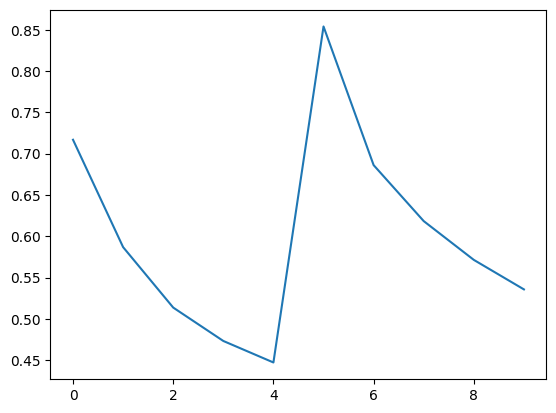

[ 6.37030000e+00  3.20000000e+01  6.00000000e+00  9.90196078e-01
  1.15900000e+03  2.27254902e+00  3.41600000e+01 -1.18410000e+02] -> [3.248032] (expected [4.658])
[ 3.55680000e+00  3.70000000e+01  4.92844677e+00  1.10471204e+00
  1.61900000e+03  2.82547993e+00  3.42600000e+01 -1.18300000e+02] -> [2.0004191] (expected [1.845])
[ 4.01890000e+00  4.30000000e+01  5.03651116e+00  1.11156187e+00
  1.21200000e+03  2.45841785e+00  3.39900000e+01 -1.18430000e+02] -> [2.4621887] (expected [3.029])
[ 1.20372000e+01  2.70000000e+01  8.27628362e+00  1.04400978e+00
  1.24800000e+03  3.05134474e+00  3.73900000e+01 -1.22130000e+02] -> [5.557487] (expected [5.00001])
[ 1.92860000e+00  2.60000000e+01  4.21264368e+00  1.07126437e+00
  2.77500000e+03  3.18965517e+00  3.42900000e+01 -1.19300000e+02] -> [1.5356146] (expected [1.605])


In [ ]:
model, best_mse, best_weights, test_mse = train_model(dropout_model, train_loader, test_loader, loss_fn, n_epochs)

# Restore the best model
model.load_state_dict(best_weights)
print("Best MSE: %.2f" % best_mse)
print("Best RMSE: %.2f" % np.sqrt(best_mse))
print("Best MSE: %.2f" % test_mse)
plt.plot(history)
plt.show()

# Test inference with 5 samples
model.eval()
with torch.no_grad():
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")